## Import Libraries

In [64]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

## Data preprocessing

### Read data

In [65]:
df = pd.read_csv('../../../../Dataset/CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [66]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [67]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [68]:
#  Scaler data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [69]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.6)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

## Model training and testing

In [70]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [71]:
# Add data for train, validation and test set
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [72]:
# Make input for DFNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

### Training process

In [73]:
model = Sequential()

model.add(Dense(128, input_dim=time_step, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam') 

In [74]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/100
21/21 [==============================] - 1s 16ms/step - loss: 0.0143 - val_loss: 0.0045
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.0019

21/21 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 9.9268e-04 - val_loss: 0.0020
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 9.0897e-04 - val_loss: 0.0019
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 8.3739e-04 - val_loss: 0.0025
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 8/100
21/21 [==============================] - 0s 6ms/step - loss: 7.6786e-04 - val_loss: 0.0016
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 6.2664e-04 - val_loss: 0.0022
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 5.8613e-04 - val_loss: 0.0015
Epoch 11/100
21/21 [==============================] - 0s 5ms/step - loss: 6.1003e-04 - val_loss:

### Validate Processing

In [75]:
train_predict=model.predict(X_train)
y_pred_val=model.predict(X_val)

21/21 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


### Testing Processing

In [76]:
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [77]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

### Evaluate Model

In [78]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)

print(f"Validation MAPE: ", val_mape)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAPE:  0.9934013094103551
Validation RMSE:  108.27576674548632
Validation MSLE:  17.21698175463545


In [79]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.9961171445467483
Testing RMSE:  59.995901674916524
Testing MSLE:  14.792172706338883


## Predicting the next 30 days

### Preparing the prediction data

In [80]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [81]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.6491425037384033], [0.6417430639266968], [0.6264720559120178], [0.6171296834945679], [0.6035022735595703], [0.5956516265869141], [0.5849252939224243], [0.5763468742370605], [0.5706011056900024], [0.5645399689674377], [0.5624071955680847], [0.562368631362915], [0.5435191988945007], [0.5379829406738281], [0.5255023837089539], [0.5125719308853149], [0.5039793252944946], [0.4990098178386688], [0.4982251524925232], [0.5000520944595337], [0.501130223274231], [0.49869242310523987], [0.48903074860572815], [0.4810658097267151], [0.4700051248073578], [0.46010252833366394], [0.4556920826435089], [0.45097485184669495], [0.45175331830978394], [0.44984543323516846]]


### Preparing the forecast date index

In [82]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [83]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

## Visualization

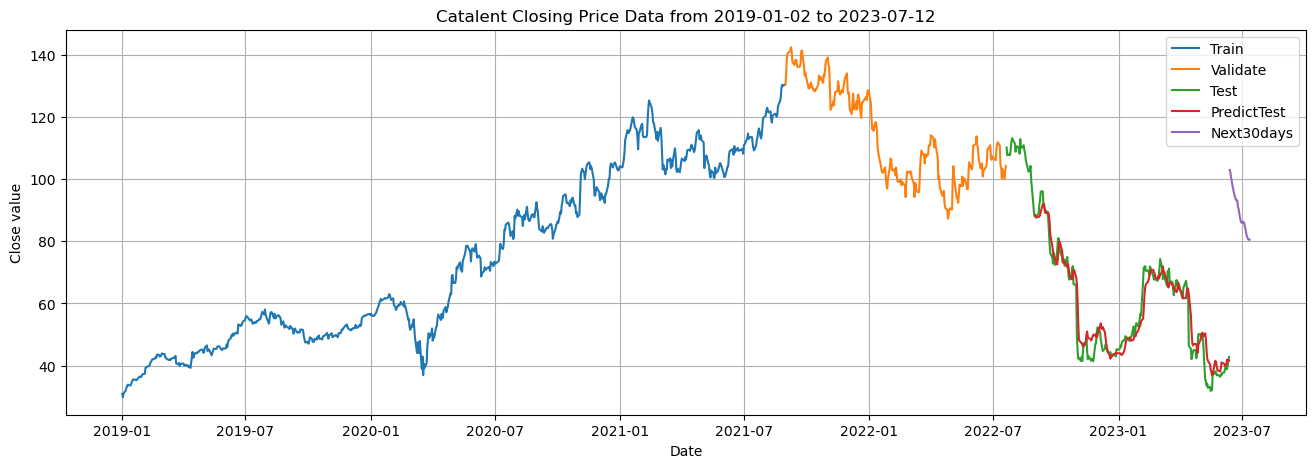

In [84]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + time_step: ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train','Validate','Test','PredictTest','Next30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from 2019-01-02 to 2023-07-12")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('../Image/DFNN_622_CTLT.png')
plt.show()